# Linear Regression Assumption Workbook

## Author: James Christensen

## Initial Date: November 6, 2025

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

### Fitting the initial model

In [6]:
full_data = pd.read_csv('../data/cleaned_data.csv')
full_data = full_data.astype({col: int for col in full_data.select_dtypes('bool').columns})


X = full_data.drop(columns = ['total_claims_paid', 'person_id'])
X = sm.add_constant(X)
y = full_data['total_claims_paid']

initial_model = sm.OLS(y, X).fit()
print(initial_model.summary())


                            OLS Regression Results                            
Dep. Variable:      total_claims_paid   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     77.51
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          3.70e-159
Time:                        10:36:04   Log-Likelihood:            -6.3978e+05
No. Observations:               69917   AIC:                         1.280e+06
Df Residuals:                   69906   BIC:                         1.280e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            896.1674     50.012     17.

Looking at the summary for this full model, it looks like a number of our variables aren't relevant to the model. The $R^2$ value being only 0.011 is fairly concerning. We'll see if the model can be better modeled with a transformation on Y. 

#### Transforming Y using box-cox

In [7]:
y = initial_model.model.endog  
y = y + 1e-6

y_boxcox, best_lambda = stats.boxcox(y)

print("Optimal lambda:", best_lambda)

Optimal lambda: 0.06744053363915475


Since the optimal lambda is essentially 0, we will perform a natural log transformation on total_claims_paid

In [8]:
y = full_data['total_claims_paid'] + 1e-6
y = np.log(y)
y_adjust_model = sm.OLS(y, X).fit()
print(y_adjust_model.summary())


                            OLS Regression Results                            
Dep. Variable:      total_claims_paid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.807
Date:                Fri, 07 Nov 2025   Prob (F-statistic):             0.0538
Time:                        10:36:04   Log-Likelihood:            -2.6181e+05
No. Observations:               69917   AIC:                         5.236e+05
Df Residuals:                   69906   BIC:                         5.237e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3008      0.225     -5.

In [9]:
y

0         7.080935
1         6.909993
2         7.106639
3       -13.815511
4         7.248547
           ...    
69912   -13.815511
69913   -13.815511
69914   -13.815511
69915     7.824238
69916     7.007383
Name: total_claims_paid, Length: 69917, dtype: float64

This model actually did worse than the original one. As a result, we will check the assumptions of the original model and see if they hold.

### Checking the assumptions

#### Independence

One of the assumptions that we make with linear regression is that the observations are independent. Since each observation is an independent person it seems that the assumption is met. One possible way where the observations way not be completely independent is if two individuals come from the same household and have the same health insurance. It is also possible that there may be some repeat individuals as the data is sourced from "publicly available health surveys, insurance research studies, and anonymized online healthcare data." If any of these issues are present, it is safe to say that they are likely so few and far between that it is appropriate to conclude that the assumption of independence is effectively upheld

#### Normality of Errors

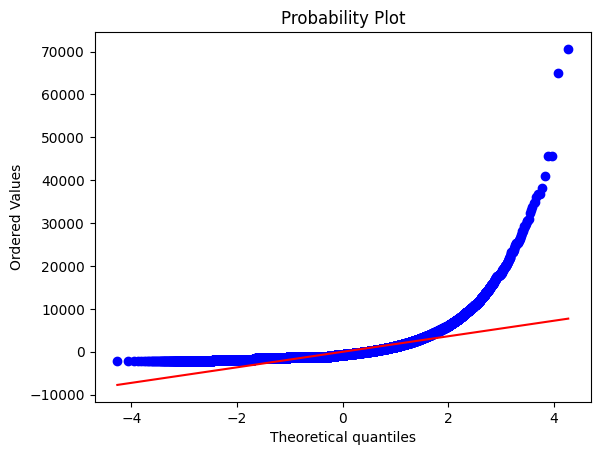

In [12]:
stats.probplot(initial_model.resid, dist = "norm", plot = plt)
plt.show()

This plot pretty clearly shows massive deviations from the theoretical quantile line. As such, it is pretty obvious that the assumption of normality is violated for the initial model. As such, we will check the other model and see if the normality assumption is violated as well

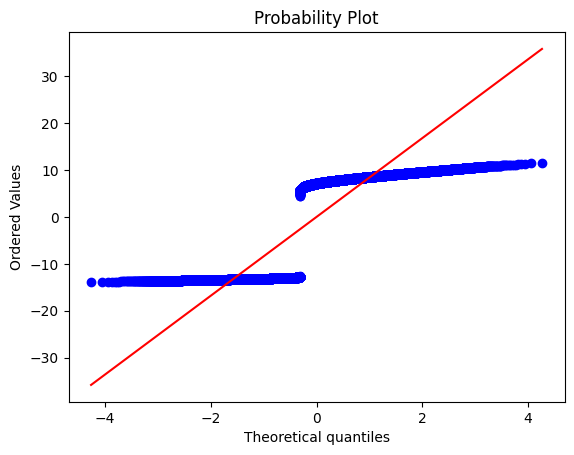

In [13]:
stats.probplot(y_adjust_model.resid, dist = "norm", plot = plt)
plt.show()

The assumption of normality is very clearly violated here as well. But it does appear to not be as extreme as the intial model. To quantify, we will use the Shapiro-Wilk test to compare which one more closely follows the theoretical quantiles

In [22]:
shapiro_i = stats.shapiro(initial_model.resid)
shapiro_y = stats.shapiro(y_adjust_model.resid)

print(f'The Shapiro-Wilk p-value for the initial model is {shapiro_i[1]}\nThe Shapiro-Wilk p-value for the adjusted model is {shapiro_y[1]}')

The Shapiro-Wilk p-value for the initial model is 1.3861329157502092e-141
The Shapiro-Wilk p-value for the adjusted model is 7.342979285513901e-138


There is essentially no alpha value at which the assumption of normality isn't violated.

#### Linearity


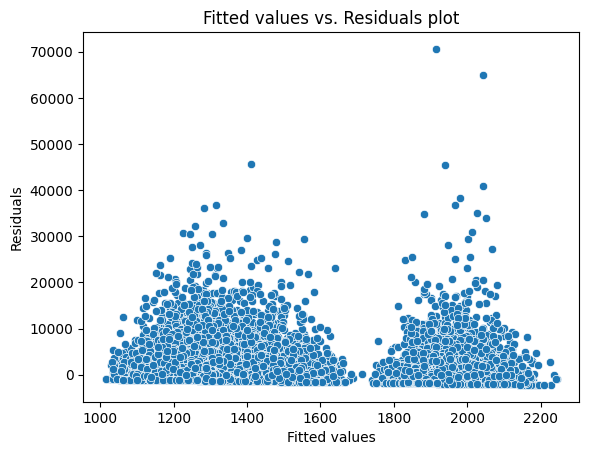

In [ ]:
sns.scatterplot(x = initial_model.fittedvalues, y = initial_model.resid)
plt.title("Fitted values vs. Residuals plot for intial model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()


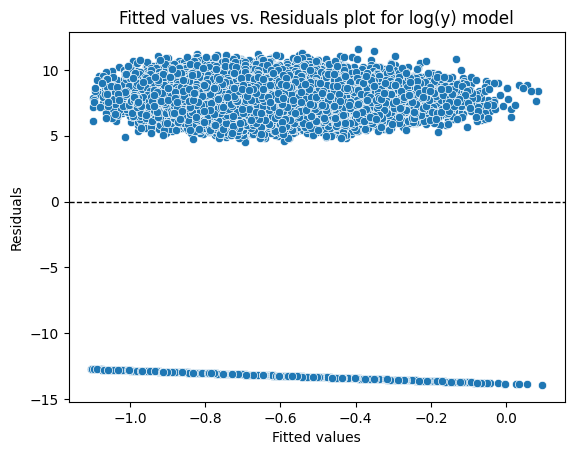

In [30]:
sns.scatterplot(x = y_adjust_model.fittedvalues, y = y_adjust_model.resid)
plt.title("Fitted values vs. Residuals plot for log(y) model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.show()